# 1 - Overview

Twitter is a mix of social network and microblogging. In this network, people post information and communicate among themselves through messages, called tweets, that can contain up to 280 characters. In this assignment, *we will implement a prototype that can detect if an airline company is positively or negatively mentioned in a tweet*. 



# 2 - Sentiment Analysis Model (13 points)

In the literature, the task of extracting the sentiment of a text is called *sentiment analysis*. We will implement a bag-of-words (BoW) model for this task.

## 2.1 -  Setup

Please run the code below to install the packages needed for this assignment.

In [1]:
# If you want, you can use anaconda and install after nltk library
# pip install --user numpy
# pip install --user sklearn
# pip install --user scipy
# pip install --user nltk


# python
import nltk
import numpy as np
import math
import copy

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/valentinbouis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valentinbouis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/valentinbouis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/valentinbouis/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## 2.2 - Dataset

Please download the zip file in the following url: https://drive.google.com/file/d/1iGmESwPXpO3sIZFGOCrysxJ27AHdly-Y/view?usp=sharing

In this zip file, there are 2 files:
1. train.tsv: training dataset
2. dev.tsv: validation dataset

Each line of the files has the following information about a tweet: *tweet id*, *user id*, *label* and *message text*.

There are three labels in the dataset: *negative*, *neutral* and *positive*. We represent each one of these labels as 0, 1 and 2 respectively.

In the code above read the training and validation datasets.

In [2]:
import codecs
import re

def load_dataset(path):
    dtFile = codecs.open(path, 'r')
    
    x = []
    y = []
    
    for l in dtFile:
        sid, uid, label,text = re.split(r"\s+", l, maxsplit=3)
        
        text = text.strip()
        
        # Remove not available
        if text == "Not Available":
            continue
        
        x.append(text)
        
        if label == "negative": 
            y.append(0)
        elif label == "neutral": 
            y.append(1)
        elif label == "positive": 
            y.append(2)
        
    assert len(x) == len(y)
            
    return x,y
            

# Path of training dataset
trainingPath="sentiment_analysis/train_data.tsv"

# Path of validation dataset
validationPath="sentiment_analysis/dev_data.tsv"

training_X, training_Y = load_dataset(trainingPath)
validation_X, validation_Y = load_dataset(validationPath)


## 2.3 - Preprocessing

Preprocessing is a crucial task in data mining. This task clean and transform the raw data in a format that can better suit data analysis and machine learning techniques. In natural language processing (NLP), *tokenization* and *stemming* are two well known preprocessing steps. Besides these two steps, we will implement an additional step that is designed exclusively for the twitter domain.

### 2.3.1 - Tokenization

In this preprocessing step, a *tokenizer* is responsible for breaking a text in a sequence of tokens (words, symbols, and punctuations). For instance, the sentence *"It's the student's notebook."* can be split into the following list of tokens: ['It', "'s", 'the', 'student', "'s", 'notebook', '.'].


#### 2.3.1.1 - Question 1 (0.5 point) 

Implement the SpaceTokenizer and NLTKTokenizer tokenizers: 
- **SpaceTokenizer** tokenizes the tokens that are separated by whitespace (space, tab, newline). This is a naive tokenizer.
- **NLTKTokenizer** uses the default method of the nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.

**All tokenizers have to lowercase the tokens.**

In [3]:


class SpaceTokenizer(object):
    """
    It tokenizes the tokens that are separated by whitespace (space, tab, newline). 
    We consider that any tokenization was applied in the text when we use this tokenizer.
    
    For example: "hello\tworld of\nNLP" is split in ['hello', 'world', 'of', 'NLP']
    """
    
    def tokenize(self, text):
        # Write your code here
        text.lower()
        tokens = text.split()
        
        # Have to return a list of tokens
        return tokens
        
class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """
    
    def tokenize(self, text):
        # Write your code here
        text.lower()
        tokens = nltk.word_tokenize(text)
        
        # Have to return a list of tokens
        return tokens

        

### 2.3.2 - Stemming

In the tweets *"I should have bought a new shoes today"* and *"I spent too much money buying games"*, the words *"buy"* and *"bought"* represent basically the same concept. Considering both words as different can unnecessarily increase the dimensionality of the problem and can negatively impact the performance of simple models. Therefore, a unique form (e.g., the root buy) can represent both words. The process to convert words with the same stem (word reduction that keeps word prefixes) to a standard form is called *stemming*.

#### 2.3.2.1 - Question 2 (0.5 point) 

Retrieve the stems of the tokens using the attribute *stemmer* from the class *Stemmer*.

In [4]:
from nltk.stem.snowball import SnowballStemmer

class Stemmer():
    
    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)
    
    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        
        # Write your code here
        tokens = [self.stemmer.stem(word) for word in tokens]
        
        # Have to return a list of stems
        return tokens
        

In [5]:
# Test du Stemmer
words = ["bought", "buy", "buying", "fighting", "fighters"]
stemer = Stemmer()
result = stemer.stem(words)
print(result)

['bought', 'buy', 'buy', 'fight', 'fighter']


### 2.3.3 - Twitter preprocessing

Sometimes only applying the default NLP preprocessing steps is not enough. Data for certain domains can have peculiar characteristics which requires specific preprocessing steps to remove the noise and create a more suitable format for the models. 

In NLP, methods store a set of words, called dictionary, and all the words out of the dictionary are considered as unknown. In this assignment, the feature space dimensionality of a model is directly related to the number of words in the dictionary. Since high-dimensional spaces can suffer from the curse of dimensionality, our goal is to create preprocessing steps that decrease vocabulary size.  

#### 2.3.3.1 - Question 3 (2.0 points)

Briefly explain and implement at least two preprocessing steps that reduce the dictionary size (number of unique words). These preprocessing steps must be related to the specific characteristic of the Twitter data. Therefore, for instance, the stop words removal will not be accepted as a preprocessing step.

We have 4 steps to preprocess a tweet after the stemmer. First we delete the emojis that could confuse the model (even if some of them could be relevant). After that we remove the identification @ as they give no information about the sentiment of the tweet. Then we remove the links. Ultimately we delete the determinants (the, a , ..)

In [5]:
class TwitterPreprocessing(object):
    
    def __init__(self):
        self.stemmer = Stemmer()
        self.tokenizer = SpaceTokenizer()
        self.emoji = [";)", ":)", ":(", ";(", ":3", "xd", ":D", ":p"]
        
        
    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        
        new_tweet = []
        for word in tweet:
            # Remove smileys
            if (word not in self.emoji 
                and not word.startswith("@") 
                and not word.startswith("http") 
                and nltk.pos_tag([word])[0][1] != 'DT'):
                new_tweet.append(word)
                
        # return the preprocessed twitter
        return new_tweet
        
        
        

### 2.3.3  Pipeline

The pipeline is sequence of preprocessing steps that transform the raw data to a format that is suitable for your problem. We implement the class *PreprocessingPipeline* that apply the tokenizer, twitter preprocessing and stemer to the text.

**Feel free to change the preprocessing order.**

In [6]:
class PreprocessingPipeline:
    
    def __init__(self, tokenization, twitterPreprocessing, stemming):
        """
        tokenization: enable or disable tokenization.
        twitterPreprocessing: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """

        self.tokenizer= NLTKTokenizer() if tokenization else SpaceTokenizer()
        self.twitterPreprocesser = TwitterPreprocessing() if twitterPreprocessing else None
        self.stemmer = Stemmer() if stemming else None
    
    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        twitterPreprocessing: boolean value. Apply the
        stemming: boolean value.
        """
        tweet = self.tokenizer.tokenize(tweet)
        
        if self.stemmer:
            tweet = self.stemmer.stem(tweet)
            
        if self.twitterPreprocesser:
            tweet = self.twitterPreprocesser.preprocess(tweet)
        
        return tweet
    

In [8]:
# Test preprocessing
pipeline = PreprocessingPipeline(False, True, True)
tweet = "I think the Airtransat company suck :( http://www.airfrance.com @Aurelien"
result = pipeline.preprocess(tweet)
print(result)

['i', 'think', 'airtransat', 'compani', 'suck']


## 2.4 N-grams

An n-gram is a contiguous sequence of *n* tokens from a text. Thus, for instance,the sequence *"bye as"* and *"walked through"* are example of 2-grams from the sentence *"He said bye as he walked through the door ."*. 1-gram, 2-gram and 3-gram are, respectively, called unigram, bigram and trigram. We list all the possible unigram, bigram and trigram from the *"He said bye as he walked through the door ."*:

- Unigram: ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
- Bigram: ["He said", "said bye", "bye as", "as he", "he walked", "walked through", "through the", "the door", "door ."] 
- Trigram: ["He said bye", "said bye as", "bye as he", "as he walked", "he walked through", "walked through the", "through the door", "the door ."] 


### 2.4.1 - Question 4 (1 point)

Implement bigram and trigram.

**For this exercise, you cannot use any external python library (e.g., scikit-learn).**

In [7]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    # Write your code here
    # This function returns the list of bigrams
    
    bigram_list = []
    for i in range(len(tokens)-1):
        bigram_list.append(tokens[i] + " " + tokens[i+1])
    return bigram_list
    #return list(nltk.bigrams(tokens))
    
def trigram(tokens):
    """
    tokens: a list of strings
    """
    # Write your code here
    # This function returns the list of trigrams
    
    trigram_list = []
    for i in range(len(tokens)-2):
        trigram_list.append(tokens[i] + " " + tokens[i+1] + " " + tokens[i+2])
    return trigram_list

In [10]:
# Test ngram
unigram = ["He", "said", "bye", "as", "he", "walked", "through", "the", "door", "."]
bigram = bigram(unigram)
trigram = trigram(unigram)
print(bigram)
print(trigram)

['He said', 'said bye', 'bye as', 'as he', 'he walked', 'walked through', 'through the', 'the door', 'door .']
['He said bye', 'said bye as', 'bye as he', 'as he walked', 'he walked through', 'walked through the', 'through the door', 'the door .']


## 2.5 Bag-of-words

Logistic regression, SVM and other well-known models only accept inputs that have the same size. However, there are some data types whose sizes are not fixed, for instance, a text can have an unlimited number of words. Imagine that we retrieve two tweets: ”Board games are much better than video games” and ”Pandemic is an awesome game!”. These sentences are respectively named as Sentence 1 and 2. Table below depicts how we could represent both sentences using a fixed representation.

|            | an | are | ! | pandemic | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |

Each column of this table 2.1 represents one of 13 vocabulary words, whereas the rows contains the word
frequencies in each sentence. For instance, the cell in row 1 and column 7 has the value 2
because the word games occurs twice in Sentence 1. Since the rows have always 13 values, we
could use those vectors to represent the Sentences 1 and 2. The table above illustrates a technique called bag-of-words. Bag-of-words represents a document as a vector whose dimensions are equal to the number of times that vocabulary words appeared in the document. Thus, each token will be related to a dimension, i.e., an integer.

### 2.5.1 - Question 5 (2 points)

Implement the bag-of-words model that weights the vector with the absolute word frequency.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)
**

In [8]:
class CountBoW(object):
    
    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.dict = []
    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, relates each unigram, bigram or trigram to a specific integer and  
        transforms the text in a vector. Vectors are weighted using the token frequencies in the sentence.
        
        X: a list that contains tweet contents
        
        :return: a list of vectors
        """   
        vector_text = []
        for x in X:
            datas = self.pipeline.preprocess(x)
            if self.trigram:
                datas += trigram(datas)
            elif self.bigram:
                datas += bigram(datas)
            for data in datas:
                if data not in vector_text:
                    vector_text.append(data)
        self.dict = vector_text
        return self.transform(X)
        
    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  transforms the text in a list of integer.
        Vectors are weighted using the token frequencies in the sentence.
        
        X: a list of vectors
        
        :return: a list of vectors
        """   
        vectors = []
        for i in range(len(X)):
            datas = self.pipeline.preprocess(X[i])
            vector = []
            for text in self.dict:
                vector.append(datas.count(text))
            vectors.append(vector)
        return vectors

In [20]:
# Test Bag of word
tweet_list = ["Hey @valentin I think you're the best !", "Totally agree I am the best", "The best chocolate is white chocolate :)"]
pipeline = PreprocessingPipeline(False, True, True)
bow = CountBoW(pipeline, True, False)
result = bow.fit_transform(copy.deepcopy(tweet_list))
result = bow.transform(copy.deepcopy(tweet_list))
print(result)

[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0]]


### 2.5.2 - TF-IDF

Using raw frequency in the bag-of-words can be problematic. The word frequency distribution
is skewed - only a few words have high frequencies in a document. Consequently, the
weight of these words will be much bigger than the other ones which can give them more
impact on some tasks, like similarity comparison. Besides that, a set of words (including
those with high frequency) appears in most of the documents and, therefore, they do not
help to discriminate documents. For instance, the word *of* appears in a significant
part of tweets. Thus, having the word *of* does not make
documents more or less similar. However, the word *terrible* is rarer and documents that
have this word are more likely to be negative. TF-IDF is a technique that overcomes the word frequency disadvantages.

TF-IDF weights the vector using inverse document frequency (IDF) and word frequency, called term frequency (TF).
TF is the local information about how important is a word to a specific document.  IDF measures the discrimination level of the words in a dataset.  Common words in a domain are not helpful to discriminate documents since most of them contain these terms. So, to reduce their relevance in the documents, these words should have low weights in the vectors . 
The following equation calculates the word IDF:
\begin{equation}
	idf_i = \log\left( \frac{N}{df_i} \right),
\end{equation}
where $N$ is the number of documents in the dataset, $df_i$ is the number of documents that contain a word $i$.
The new weight $w_{ij}$ of a word $i$ in a document $j$ using TF-IDF is computed as:
\begin{equation}
	w_{ij} = tf_{ij} \times idf_i,
\end{equation}
where $tf_{ij}$ is the term frequency of word $i$ in the document $j$.




### 2.5.2.1 - Question 6 (3 points)

Implement a bag-of-words model that weights the vector using TF-IDF.

**For this exercise, you cannot use any external python library (e.g., scikit-learn). However, if you have a problem with memory size, you can use the class scipy.sparse.csr_matrix (https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html)**

In [9]:
class TFIDFBoW(object):
    
    def __init__(self, pipeline, bigram=False, trigram=False):
        """
        pipelineObj: instance of PreprocesingPipeline
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        """
        self.pipeline = pipeline
        self.bigram = bigram
        self.trigram = trigram
        self.bow = []

        
    def fit_transform(self, X):
        """
        This method preprocesses the data using the pipeline object, calculates the IDF and TF and 
        transforms the text in vectors. Vectors are weighted using TF-IDF method.
        
        X: a list that contains tweet contents
        
        :return: a list that contains the list of integers
        """

        self.bow = []
        for x in X:
            datas = self.pipeline.preprocess(x)
            if self.trigram:
                datas += trigram(datas)
            elif self.bigram:
                datas += bigram(datas)
            for data in datas:
                if data not in self.bow:
                    self.bow.append(data)
        return self.transform(X)
        
        
    def transform(self, X):
        """
        This method preprocesses the data using the pipeline object and  
            transforms the text in a list of integer.
        
        X: a list of tweet
        
        :return: a list of vectors
        """        
        
        # transform the dataset to bag-of-words

        tweet_datas = []
        for x in X:
            datas = self.pipeline.preprocess(x)
            tweet_datas.append(datas)
        
        vector = []
        for tweet in tweet_datas:
            tweet_vec = []
            for word in self.bow:
                tweet_vec.append(tweet.count(word))
            vector.append(tweet_vec)
        clipedBow = np.clip(np.array(vector), a_min = 0, a_max = 1) 
        dfiVector = np.sum(clipedBow,axis=0)
        idfiVector = np.zeros_like(dfiVector).astype('float')
        for i in range(0,dfiVector.shape[0]):
            idfiVector[i] = math.log(len(X)/ (1+ dfiVector[i]),2)
        vector = np.array(vector,dtype='f')
        for i in range(0,vector.shape[0]):
            vector[i] = vector[i] * idfiVector
        return vector
    

In [24]:
# Test Bag of word
tweet_list = ["Hey @valentin I think you're the best !", "Totally agree I am the best", "The best chocolate is white chocolate :)"]
pipeline = PreprocessingPipeline(False, True, True)
bow = TFIDFBoW(pipeline, True, True)
result = bow.fit_transform(copy.deepcopy(tweet_list))
result = bow.transform(copy.deepcopy(tweet_list))
print(result)

[[ 0.5849625  0.         0.5849625  0.5849625 -0.4150375  0.5849625
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        -0.4150375  0.
   0.         0.         0.         0.         0.5849625  0.5849625
   0.5849625  0.         0.         0.         0.         0.
   0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.        -0.4150375  0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         1.169925   0.5849625
   0.5849625  0.         0.         0.       ]]


## 2.6 - Classifier using BoW

We are going to use logistic regression as a classifier. Read the following page to now more about this classifier: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


The method *train_evaluate* trains and evaluates the logistic regression model.

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def train_evaluate(training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """
    
    classifier = LogisticRegression()
    training_rep = bowObj.fit_transform(training_X)
    
    classifier.fit(training_rep, training_Y)
   
    trainAcc = accuracy_score(training_Y,classifier.predict(training_rep))
    validationAcc = accuracy_score(validation_Y,classifier.predict(bowObj.transform(validation_X)))
    
    return classifier, trainAcc, validationAcc


### 2.6.1 - Question 7 (4 points)

Train and calculate the logistic regression accuracy in the *training and validation dataset* using each one of the following configurations:
    1. CountBoW + SpaceTokenizer(without tokenizer) + unigram 
    2. CountBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + unigram
    3. TFIDFBoW + NLTKTokenizer + Stemming + unigram
    4. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram
    5. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram
    6. TFIDFBoW + NLTKTokenizer + Twitter preprocessing + Stemming  + unigram + bigram + trigram
Besides the accuracy, you have to report the dictionary size for each one of configurations. Finally, describe the results found by you and answer the following questions:
- Which preprocessing has helped the model? Why?
- TF-IDF has achieved a better performance than CountBoW? If yes, why do you think that this has occurred? 
- Has the bigram and trigram improved the performance? If yes, can you mention the reasons of this improvement?

In [91]:
model1 = CountBoW(PreprocessingPipeline(False, False, False), False, False)

result_model1, train_accuracy1, validation_accuracy1 =  train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model1)

print("modele 1 accuracy => (train : " + str(train_accuracy1) + ", validation : " + str(validation_accuracy1) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 1 accuracy => (train : 0.9950124688279302, validation : 0.5948808473080318 )


In [92]:
model2 = CountBoW(PreprocessingPipeline(True, False, False), False, False)
result_model2, train_accuracy2, validation_accuracy2 = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model2)
print("modele 2 accuracy => (train : " + str(train_accuracy2) + ", validation : " + str(validation_accuracy2) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 2 accuracy => (train : 0.9901716297491565, validation : 0.6275375110326566 )


In [93]:
model3 = TFIDFBoW(PreprocessingPipeline(True, False, False), False, False)
result_model3, train_accuracy3, validation_accuracy3 = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model3)
print("modele 3 accuracy => (train : " + str(train_accuracy3) + ", validation : " + str(validation_accuracy3) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 3 accuracy => (train : 0.9992665395335192, validation : 0.6284201235657546 )


In [11]:
model3bis = TFIDFBoW(PreprocessingPipeline(True, False, True), False, False)
result_model3bis, train_accuracy3bis, validation_accuracy3bis = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model3bis)
print("modele 3bis accuracy => (train : " + str(train_accuracy3bis) + ", validation : " + str(validation_accuracy3bis) + " )")


/Users/valentinbouis/POLYMTL/INF8111/TP/TP1/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/valentinbouis/POLYMTL/INF8111/TP/TP1/env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 3bis accuracy => (train : 0.9992665395335192, validation : 0.6425419240953222 )


In [95]:
model4 = TFIDFBoW(PreprocessingPipeline(True, True, True), False, False)
result_model4, train_accuracy4, validation_accuracy4 = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model4)
print("modele 4 accuracy => (train : " + str(train_accuracy4) + ", validation : " + str(validation_accuracy4) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 4 accuracy => (train : 0.9992665395335192, validation : 0.6319505736981466 )


In [21]:
model5 = TFIDFBoW(PreprocessingPipeline(True, True, True), True, False)
result_model5, train_accuracy5, validation_accuracy5 = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model5)
print("modele 5 accuracy => (train : " + str(train_accuracy5) + ", validation : " + str(validation_accuracy5) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 5 accuracy => (train : 0.9992665395335192, validation : 0.6319505736981466 )


In [27]:
model6 = TFIDFBoW(PreprocessingPipeline(True, True, True), True, True)
result_model6, train_accuracy6, validation_accuracy6 = train_evaluate(copy.deepcopy(training_X), training_Y, copy.deepcopy(validation_X), validation_Y, model6)
print("modele 6 accuracy => (train : " + str(train_accuracy6) + ", validation : " + str(validation_accuracy6) + " )")


c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\benja\onedrive\documents\cours\inf8111\venv\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


modele 6 accuracy => (train : 0.9992665395335192, validation : 0.6328331862312445 )


# 3 Prototype (7 points)

During the last years, *E Corp* has collected tweets to create a dataset to their sentiment analysis tool. Now, airline companies have contracted *E Corp* to analyze the consumer opinion about them. Your job is to extract information from the tweet database about the following companies: Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.

*For the prototype, you have to use the best model found in the Section 2.*

## 3.1 Dataset

In https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing, you can find the raw tweet retrieved by E corp.  Each tweet is represented as json that the have attributes listed in the page https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.

** You will answer the question of this section using this tweet database (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing).**

## 3.2 Sentiment Analysis


### 3.2.1 Question 8 (0.5 point)

Implement the method *extract_tweet_content* that extracts the content of each tweet in the database.

In [12]:
def extract_tweet_content(raw_tweet_file):
    """
    Extract the tweet content for each json object
    
    raw_tweet_file: file path that contains all json objects
    
    :return: a list with the tweet contents
    """
    import json
    tweets = []
    for line in open(raw_tweet_file, 'r'):
        tweets.append(json.loads(line))
    tweets_content = []
    for tweet in tweets:
        tweets_content.append(tweet['text'])
    return tweets_content
    
    
#extract_tweet_content('sentiment_analysis/e_corp_dataset.txt')
    

### 3.2.1 Question 9 (1 points)

Implement the method *detect_airline* that detects the airline companies in a tweet. Besides that, explain your approach to detect the companies and its possible drawbacks.

The detect_airline has to be able to return if none or more than one airline companies are mentioned in a tweet

In [13]:

def detect_airline(tweet):
    """
    Detect and return the airline companies mentioned in the tweet
    
    tweet: represents the tweet message. You should define the data type
    
    :return: list of detected airline companies
    """
    
    y = [0] * 8
    airline_companies = ["British_Airways", "united", "united airlines", "unitedairlines", "UnitedAirlines","SouthwestAir", "Southwest Airlines", "AmericanAir", "USAirways", "Air France", "VirginAmerica","DeltaAirlines", "@Delta", "Virgin America", "British Airways", "American Air", "US Airways", "Delta Airlines", "airfrance"]

    if tweet.find(airline_companies[0]) != -1 :
        y[2] = 1
    if tweet.find(airline_companies[1]) != -1 :
        y[5] = 1
    if tweet.find(airline_companies[2]) != -1 :
        y[5] = 1
    if tweet.find(airline_companies[3]) != -1 :
        y[5] = 1
    if tweet.find(airline_companies[4]) != -1 :
        y[5] = 1
    if tweet.find(airline_companies[5]) != -1 :
        y[4] = 1
    if tweet.find(airline_companies[6]) != -1 :
        y[4] = 1
    if tweet.find(airline_companies[7]) != -1 :
        y[1] = 1
    if tweet.find(airline_companies[8]) != -1 :
        y[6] = 1
    if tweet.find(airline_companies[9]) != -1 :
        y[0] = 1
    if tweet.find(airline_companies[10]) != -1 :
        y[7] = 1
    if tweet.find(airline_companies[11]) != -1 :
        y[3] = 1
    if tweet.find(airline_companies[12]) != -1 :
        y[3] = 1
    if tweet.find(airline_companies[13]) != -1: # virgin america
        y[7] = 1
    if tweet.find(airline_companies[14]) != -1: #British Air
        y[2] = 1 
    if tweet.find(airline_companies[15]) != -1: #American Air
        y[1] = 1 
    if tweet.find(airline_companies[16]) != -1: # US Airways
        y[6] = 1 
    if tweet.find(airline_companies[17]) != -1: # Delta
        y[3] = 1 
    if tweet.find(airline_companies[18]) != -1:  #Air france
        y[0] = 1 
    return y

tweet = "@SouthwestAir can't fly in precipitation and @Delta has planes that don't work after 5. 3rd airline had better be a charm tomorrow."
detect_airline(tweet)


[0, 0, 0, 1, 1, 0, 0, 0]


### 3.2.1 Question 10 (0.5 points)

Implement the method *extract_sentiment* that receives a tweet and extracts its sentiment.

In [14]:
def extract_sentiment(classifier, tweet):
    """
    Extract the tweet sentiment
    
    classifier: classifier object
    tweet: represents the tweet message. You should define the data type
    
    :return: list of detected airline companies
    """
    return classifier.predict(model3bis.transform([tweet]))[0]



### 3.2.1 Question 11 (2 points)

Using the *extract_tweet_content*, *detect_airline* and *extract_sentiment*, implement a code that generates a bar chart that contains the number of positive, neutral and negatives tweets for each one of the companies. Briefly describe your bar chart (e.g, which was the company with most negative tweets) and how this chart can help airline companies.   

In [15]:
import matplotlib.pyplot as plt
tweets = extract_tweet_content('sentiment_analysis/e_corp_dataset.txt')
tweet_positif_or_negatif = []
def get_tweets_by_category():
    category_all = []
    for index_tweet in range(len(tweets)):
        tweet = tweets[index_tweet]
        vector_category = detect_airline(tweet)
        if 1 in vector_category:
            for index in range(len(vector_category)):
                val = vector_category[index]
                if val == 1:
                    category_all.append((index_tweet, index))
    return category_all

predict_air_france = []
predict_american = []
predict_british_airways = []
predict_delta = []
predict_southwest = []
predict_united = []
predict_us_airways = []
predict_virgin_america = []

tweet_air_france = []
tweet_american = []
tweet_british_airways = []
tweet_delta = []
tweet_southwest = []
tweet_united = []
tweet_us_airways = []
tweet_virgin_america = []

for index_tweet, id_category in get_tweets_by_category() : 
    sentiment = extract_sentiment(result_model3bis, tweets[index_tweet])
    if sentiment == 0 or sentiment == 2 :
            tweet_positif_or_negatif.append(tweets[index_tweet])   
    if id_category == 0 :
        predict_air_france.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_air_france.append(tweets[index_tweet])
    if id_category == 1 :
        predict_american.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_american.append(tweets[index_tweet])
    if id_category == 2 :
        predict_british_airways.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_british_airways.append(tweets[index_tweet])
    if id_category == 3 :
        predict_delta.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_delta.append(tweets[index_tweet])
    if id_category == 4 :
        predict_southwest.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_southwest.append(tweets[index_tweet])
    if id_category == 5 :
        predict_united.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_united.append(tweets[index_tweet])
    if id_category == 6 :
        predict_us_airways.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_us_airways.append(tweets[index_tweet])
    if id_category == 7 :
        predict_virgin_america.append(sentiment)
        if sentiment == 0 or sentiment == 2 :
            tweet_virgin_america.append(tweets[index_tweet])



<Figure size 640x480 with 1 Axes>

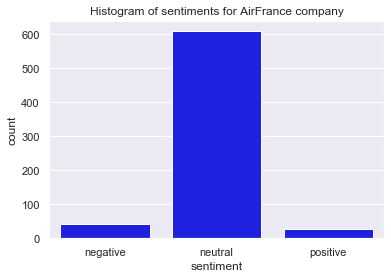

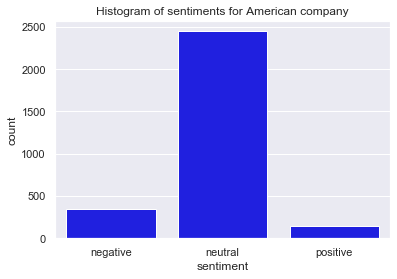

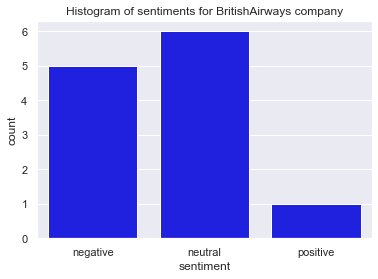

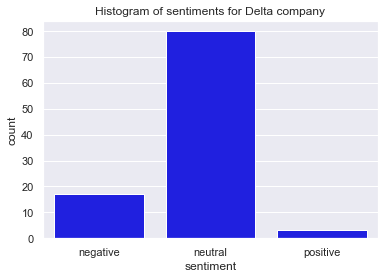

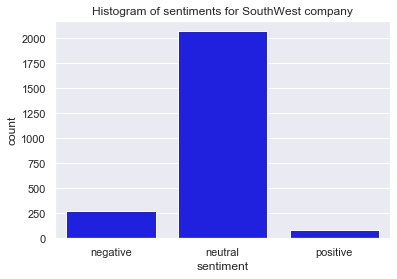

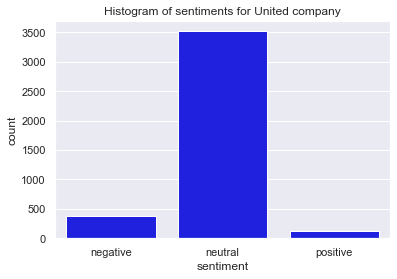

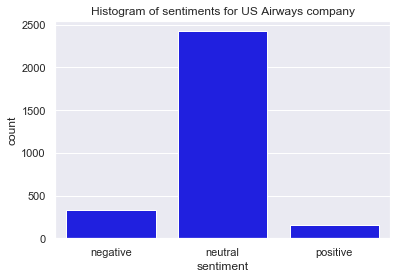

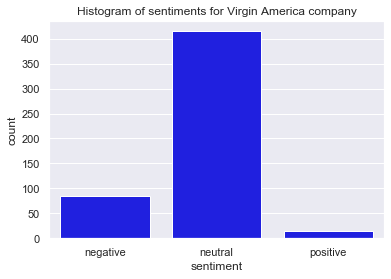

In [43]:
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

def show_histogram(sentiment, name):
    df = pd.DataFrame({'sentiment': sentiment})
    plot = sns.countplot(df['sentiment'], color='blue').set_xticklabels(["negative", "neutral", "positive"])
    plt.title("Histogram of sentiments for {} company".format(name))
    plt.show()

show_histogram(predict_air_france, "AirFrance")
show_histogram(predict_american, "American")
show_histogram(predict_british_airways, "BritishAirways")
show_histogram(predict_delta, "Delta")
show_histogram(predict_southwest, "SouthWest")
show_histogram(predict_united, "United")
show_histogram(predict_us_airways, "US Airways")
show_histogram(predict_virgin_america, "Virgin America")







#predict_air_france.value_counts().plot(kind='bar')
#plt.hist(predict_air_france, 3, facecolor='blue', alpha=0.5)


## 3.3 - Term Analysis

POS-tagging consists of extracting the part-of-speech (POS) of each token in a sentence. For instance, the table below depicts the part-of-speechs of the sentence *The cat is white!* are.



|   The   | cat  |  is  | white     |    !       |
|---------|------|------|-----------|------------|
| article | noun | verb | adjective | punctation |


The part-of-speech can be more complex than what we have learned in the school. Linguistics need to have a more detailed information about systax information of the words in a sentence. For our problem, we do not need this level of information and, thus, we will use a less complex set, called universal POS tags. 

In POS-tagging, each part-of-speech is represented by a tag. You can find the POS tag list used in this assignement at https://universaldependencies.org/u/pos/ .

In [65]:
# NLTK POS-tagger

import nltk


#before using pos_tag function, you have to tokenize the sentence.
s = ['The', 'cat', 'is',  'white', '!']
nltk.pos_tag(s,tagset='universal')


[('The', 'DET'), ('cat', 'NOUN'), ('is', 'VERB'), ('white', 'ADJ'), ('!', '.')]

### 3.3.1 Question 12 (2 points)

**Implement a code** that retrieves the top 10 most frequent terms for each airline company. You will only consider the terms that appear in a positive and negative tweets. Besides that, we consider as term:
1. Words that are either an adjective or a noun
2. n-grams that are composed by adjectives followed by a noun (e.g., dirty place) or a noun followed by another noun (e.g.,sports club).

Moreover, **generate a table** with the top 10 most frequent terms and their normalized frequencies(percentage) for each airline company.

**Do not forget to remove the company names from the chart.**

In [92]:
pipeline = PreprocessingPipeline(False, False, False)

bow = CountBoW(pipeline, True, True)
print(len(tweet_positif_or_negatif))
fit_transform_bow = bow.fit_transform(copy.deepcopy(tweet_positif_or_negatif))
print('fit fini')
vector_count_air_france = bow.transform(copy.deepcopy(tweet_air_france))
print('air france fini')
vector_count_american = bow.transform(copy.deepcopy(tweet_american))
print('american')
vector_count_british = bow.transform(copy.deepcopy(tweet_british_airways))
print('british fini')
vector_count_delta = bow.transform(copy.deepcopy(tweet_delta))
print('delta fini')
vector_count_southwest = bow.transform(copy.deepcopy(tweet_southwest))
print('south west fini')
vector_count_united = bow.transform(copy.deepcopy(tweet_united))
print('united fini')
vector_count_airways = bow.transform(copy.deepcopy(tweet_us_airways))
print('air united fini')
vector_count_virgin = bow.transform(copy.deepcopy(tweet_virgin_america))
print('virgin fini')



2034
fit fini
air france fini
american
british fini
delta fini
south west fini
united fini
air united fini
virgin fini


In [98]:
result_air_france = [x for _,x in sorted(zip(vector_count_air_france,bow.dict), reverse=True)]
result_air_france = nltk.pos_tag(result_air_france,tagset='universal')
result_air_france

[('goes', 'VERB'),
 ('was already found', 'NOUN'),
 ('and', 'CONJ'),
 ('Love', 'NOUN'),
 ('court', 'NOUN'),
 ('there', 'DET'),
 ('that there are', 'NOUN'),
 ('Virgin is bumping', 'VERB'),
 ('@b0tsk33', 'ADJ'),
 ('@VirginAmerica @JezzieGoldz club', 'NOUN'),
 ('in', 'ADP'),
 ('is', 'VERB'),
 ('confirmed', 'VERB'),
 ('confirmed that there', 'ADJ'),
 ('Field', 'NOUN'),
 ('found', 'VERB'),
 ('Air France was', 'NOUN'),
 ('gates at Love', 'NOUN'),
 ('to', 'PRT'),
 ('access to @Delta', 'VERB'),
 ('survivors.', 'ADJ'),
 ('New', 'NOUN'),
 ('http://t.co/ILqzmMJiYQ', 'NOUN'),
 ('court to gain', 'NOUN'),
 ('is bumping in', 'ADJ'),
 ('Field http://t.co/ILqzmMJiYQ #deltanews', 'NOUN'),
 ('gates', 'NOUN'),
 ('already found and', 'VERB'),
 ('http://lev.me/AF447', 'ADJ'),
 ('club Virgin is', 'NOUN'),
 ('gain', 'NOUN'),
 ('Air', 'NOUN'),
 ('are no survivors.', 'VERB'),
 ('no', 'DET'),
 ('@VirginAmerica', 'NOUN'),
 ('goes to court', 'NOUN'),
 ('France was already', 'NOUN'),
 ('there are no', 'NOUN'),
 ('L

### 3.3.2 Question 13 (1 point)

The table generated in the Question 12 can lead us to any conclusion about each one of the 9 companies? Can we identify specific events that have occured during the data retrieval?

# 4 - Bonus (2 points)

Person names, companies names and locations are called named entities. Named-entity recognition (NER) is the task of extracting named entities  classifying them using pre-defined categories. In this bonus section, you will use a Named Entity Recognizer to automatically extract named entities from the tweets. This approach is generic enough to retrieve information about other companies or even product and people names.

**For the bonus, you are free to use any Named Entity Recognizer that has python wrapper or is implemented in python. Moreover, you have to use the tweet database of the previous section (https://drive.google.com/file/d/1Cuw6Y12Bj91vF_iH49mqPZZfJkY92iBY/view?usp=sharing)**


## 4.1 - Bonus 2 (1 point)

Implement a code that generates the table with the top 10 most mentioned named entities in the database (this table has to contain the frequencies of the name entities). After that, generates a bar chart that despicts the number of positive, negative and neutral tweets for each one of these 10 named entities. Briefly describe the results found in the bar chart.

*Ignore the named entities related to the following airline companies : Air France, American, British Airways,  Delta, Southwest, United, Us Airways and Virgin America.*

## 4.2 - Bonus 3 (1 point)

Generate a similar table produced in the Question 12 for the 10 most mentioned named entities in Bonus 2. Can we draw any conclusion about these named entities?